## Imports

In [2]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import time

#from core.data_processor_train_test import DataLoader
#from core.model_train_test import Model
#from core.talib2 import TaLib
from core.talib_top6 import TaLib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


## Carregar os Dados e Gerar os Indicadores Técnicos

In [7]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('configs/config.json', 'r'))
models = json.load(open('configs/modelo.json', 'r'))

In [8]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(models['model']['save_dir']):
            os.makedirs(models['model']['save_dir'])

In [9]:
# Carregar o Dataset
datapath = os.path.join('dataset', configs['dataset']['filename'])
data = pd.read_csv(datapath)
data.columns.array

<PandasArray>
[  'DATE',   'TIME',   'OPEN',   'HIGH',    'LOW',  'CLOSE',    'VOL',
   'vwap',  'sma20',  'sma60',  'sma80', 'sma200', 'sma400', 'sma600']
Length: 14, dtype: object

In [10]:
# Selecionar apenas as colunas com OHLCV
data_ohlcv = data.drop(['vwap',  'sma20',  'sma60',  'sma80', 'sma200', 'sma400', 'sma600'], axis=1)
print(data_ohlcv.shape)
data_ohlcv.head(1)

(139904, 7)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,2014.11.19,10:50:00,53010,53175,53000,53155,4099


In [11]:
# Verificando se existem dados faltantes
data_ohlcv.isnull().sum()

DATE     0
TIME     0
OPEN     0
HIGH     0
LOW      0
CLOSE    0
VOL      0
dtype: int64

In [12]:
# Carregando cada coluna do dataframe em vetores 
input_candlesticks = {
                        'date': np.array(data_ohlcv['DATE'].astype(str)),
                        'time': np.array(data_ohlcv['TIME'].astype(str)),
                        'open': np.array(data_ohlcv['OPEN'].astype(float)),
                        'high': np.array(data_ohlcv['HIGH'].astype(float)),
                        'low': np.array(data_ohlcv['LOW'].astype(float)),
                        'close': np.array(data_ohlcv['CLOSE'].astype(float)),
                        'volume': np.array(data_ohlcv['VOL'].astype(float))
                    }
 # Gerar os TIs através do TaLib
indicadores = TaLib(input_candlesticks)
indicadores_DB = indicadores.lista_de_indicadores()
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139904, 13)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV
0,2014.11.19,10:50:00,53010.0,53175.0,53000.0,53155.0,4099.0,NaN,NaN,NaN,NaN,NaN,4099.0
1,2014.11.19,10:55:00,53150.0,53230.0,53130.0,53165.0,3745.0,NaN,NaN,NaN,NaN,NaN,7844.0


In [13]:
# Verificando se existem dados faltantes
indicadores_DB.isnull().sum()

DATE       0
TIME       0
OPEN       0
HIGH       0
LOW        0
CLOSE      0
VOL        0
EMA_20    19
ADX_6     11
MOM_6      6
ROC_5      5
RSI_10    10
OBV        0
dtype: int64

In [14]:
# Apagando linhas com dados NaN
indicadores_DB.dropna(axis=0, inplace=True)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139885, 13)


,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV
19,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,320.0,0.591605,68.670278,25358.0
20,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,165.0,0.150009,56.517372,16995.0


In [15]:
# Concatenar colunas 'DATE' e 'TIME' e converter para DateTime
indicadores_DB['DATETIME'] = indicadores_DB[['DATE', 'TIME']].agg(' '.join, axis=1)
# indicadores_DB.drop(['DATE', 'TIME'], axis=1,inplace=True)
indicadores_DB['DATETIME'] = pd.to_datetime(indicadores_DB['DATETIME'])

col = indicadores_DB.pop("DATETIME")
indicadores_DB.insert(0, col.name, col)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139885, 14)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV
19,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,320.0,0.591605,68.670278,25358.0
20,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,165.0,0.150009,56.517372,16995.0


In [16]:
# Ajustar o index do DataFrame
indicadores_DB = indicadores_DB.reset_index()
indicadores_DB.drop('index', axis=1, inplace=True)
print(indicadores_DB.shape)
indicadores_DB.head(2)

(139885, 14)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,320.0,0.591605,68.670278,25358.0
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,165.0,0.150009,56.517372,16995.0


### Criação de Novas Features

In [17]:
indicadores_DB['MES'] = indicadores_DB['DATETIME'].dt.month
indicadores_DB['DIA_SEMANA'] = indicadores_DB['DATETIME'].dt.weekday

def define_period(num):
    #print(type(num))
    if num.hour <= 11:
        if num.hour < 10:
            if (num.minute < 30):
                return '0'
        return '1'
    elif num.hour < 16:
        return '2'
    else:
        return '3'

# 09:00 -> 09:25 = 0    
# 09:30 -> 11:55 = 1
# 12:00 -> 15:55 = 2
# 16:00 -> 18:00 = 3

indicadores_DB['HORA_NOBRE'] = indicadores_DB['DATETIME'].map(define_period)
print(indicadores_DB.shape)


(139885, 17)


In [18]:
indicadores_DB.iloc[60:80, :]

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE
60,2014-11-19 17:25:00,2014.11.19,17:25:00,54065.0,54130.0,54015.0,54040.0,6180.0,53549.692500,78.111476,340.0,0.315575,80.930999,30862.0,11,2,3
61,2014-11-19 17:30:00,2014.11.19,17:30:00,54040.0,54060.0,53935.0,53945.0,3612.0,53587.340834,75.068939,75.0,0.232256,72.009203,27250.0,11,2,3
62,2014-11-19 17:35:00,2014.11.19,17:35:00,53940.0,53950.0,53800.0,53820.0,3785.0,53609.498849,65.698262,0.0,0.065074,62.014408,23465.0,11,2,3
63,2014-11-19 17:40:00,2014.11.19,17:40:00,53820.0,53890.0,53785.0,53835.0,4255.0,53630.975150,57.234222,50.0,-0.166898,62.704615,27720.0,11,2,3
64,2014-11-19 17:45:00,2014.11.19,17:45:00,53840.0,53880.0,53820.0,53850.0,1914.0,53651.834659,50.180856,-75.0,-0.379243,63.442677,29634.0,11,2,3
65,2014-11-19 17:50:00,2014.11.19,17:50:00,53850.0,53900.0,53750.0,53810.0,3147.0,53666.898025,42.814529,-245.0,-0.425611,59.928702,26487.0,11,2,3
66,2014-11-19 18:01:01,2014.11.19,18:01:01,53820.0,53820.0,53820.0,53820.0,1521.0,53681.479165,36.675923,-220.0,-0.231717,60.535881,28008.0,11,2,3
67,2014-11-21 09:00:00,2014.11.21,09:00:00,54400.0,54500.0,54280.0,54440.0,2960.0,53753.719245,42.245504,495.0,1.151988,80.691166,30968.0,11,4,0
68,2014-11-21 09:05:00,2014.11.21,09:05:00,54465.0,54585.0,54445.0,54505.0,2600.0,53825.269793,47.371339,685.0,1.244544,81.775401,33568.0,11,4,0
69,2014-11-21 09:10:00,2014.11.21,09:10:00,54490.0,54545.0,54420.0,54535.0,1423.0,53892.863146,50.686463,700.0,1.272052,82.285509,34991.0,11,4,0


In [19]:
indicadores_DB[['DATETIME', 'HORA_NOBRE']].iloc[60:80, :]

,DATETIME,HORA_NOBRE
60,2014-11-19 17:25:00,3
61,2014-11-19 17:30:00,3
62,2014-11-19 17:35:00,3
63,2014-11-19 17:40:00,3
64,2014-11-19 17:45:00,3
65,2014-11-19 17:50:00,3
66,2014-11-19 18:01:01,3
67,2014-11-21 09:00:00,0
68,2014-11-21 09:05:00,0
69,2014-11-21 09:10:00,0


<AxesSubplot:xlabel='DATETIME'>

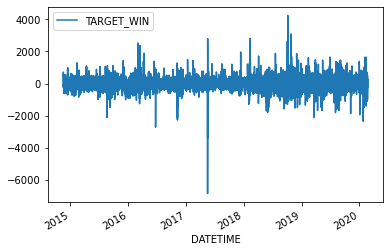

In [20]:
# Criando a coluna Target com diff(horizonte de previsão)
horizon = configs['dataset']['horizon']
indicadores_DB['TARGET_WIN'] = indicadores_DB['CLOSE'].diff(periods=horizon).shift(-horizon)
indicadores_DB.plot(x='DATETIME', y='TARGET_WIN')

In [21]:
indicadores_DB['TARGET_WIN'].describe()

count    139882.000000
mean          1.297308
std         170.642091
min       -6855.000000
25%         -75.000000
50%           0.000000
75%          75.000000
max        4245.000000
Name: TARGET_WIN, dtype: float64

In [22]:
indicadores_DB.groupby(['HORA_NOBRE'])['TARGET_WIN'].describe()

,count,mean,std,min,25%,50%,75%,max
HORA_NOBRE,,,,,,,,
0,7742.0,1.803797,140.271911,-1485.0,-65.0,5.0,70.0,1030.0
1,38759.0,-0.659718,169.577108,-3400.0,-90.0,0.0,90.0,2795.0
2,62230.0,-0.798088,129.679558,-1570.0,-70.0,0.0,70.0,1315.0
3,31151.0,7.792366,237.568781,-6855.0,-70.0,5.0,75.0,4245.0


<AxesSubplot:>

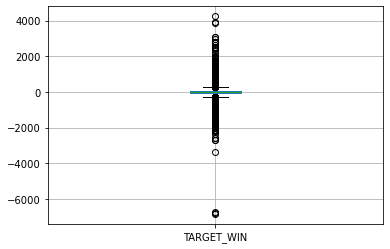

In [23]:
indicadores_DB.boxplot('TARGET_WIN')

In [24]:
indicadores_DB.query('TARGET_WIN < -6000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN
66039,2017-05-17 17:40:00,2017.05.17,17:40:00,68000.0,68040.0,67995.0,68035.0,3798.0,67932.641213,31.250099,35.0,0.088268,66.446660,-409206.0,5,2,3,-6855.0
66040,2017-05-17 17:45:00,2017.05.17,17:45:00,68040.0,68050.0,67930.0,67930.0,4868.0,67932.389669,27.403466,-45.0,0.014723,49.469945,-414074.0,5,2,3,-6750.0
66041,2017-05-17 17:50:00,2017.05.17,17:50:00,67940.0,68010.0,67930.0,67985.0,5819.0,67937.400176,24.197938,65.0,0.036786,56.011101,-408255.0,5,2,3,-6805.0


In [25]:
indicadores_DB.query('TARGET_WIN > 2000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,MOM_6,ROC_5,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN
33672,2016-03-03 17:55:00,2016.03.03,17:55:00,47880.0,47990.0,47780.0,47785.0,3974.0,47624.673091,41.341957,160.0,-0.073191,59.970982,-417866.0,3,3,3,2525.0
33673,2016-03-03 18:00:00,2016.03.03,18:00:00,47785.0,47820.0,47700.0,47745.0,2939.0,47636.132796,35.785900,-75.0,-0.177713,56.905009,-420805.0,3,3,3,2435.0
34653,2016-03-16 17:40:00,2016.03.16,17:40:00,48440.0,48630.0,48435.0,48595.0,3631.0,48179.299259,45.008136,480.0,0.746346,79.510033,-330386.0,3,2,3,2365.0
34654,2016-03-16 17:45:00,2016.03.16,17:45:00,48585.0,48590.0,48460.0,48490.0,2777.0,48208.889806,49.653668,255.0,0.217009,68.907738,-333163.0,3,2,3,2170.0
34655,2016-03-16 17:50:00,2016.03.16,17:50:00,48480.0,48560.0,48460.0,48560.0,4003.0,48242.328872,53.524945,175.0,0.517491,71.702778,-329160.0,3,2,3,2030.0
66062,2017-05-18 10:47:00,2017.05.18,10:47:00,57800.0,57820.0,57780.0,57780.0,2084.0,61682.228558,96.988025,-3400.0,-5.557372,0.609269,-412233.0,5,3,1,2795.0
85747,2018-02-09 17:55:00,2018.02.09,17:55:00,81165.0,81175.0,80905.0,81000.0,11504.0,80776.920688,41.741154,205.0,0.185529,56.059072,379731.0,2,4,3,2535.0
85748,2018-02-09 18:00:00,2018.02.09,18:00:00,80990.0,80990.0,80735.0,80810.0,10529.0,80780.071098,37.724157,-40.0,-0.400567,50.440684,369202.0,2,4,3,2815.0
85749,2018-02-09 18:05:00,2018.02.09,18:05:00,80810.0,81110.0,80800.0,81000.0,9886.0,80801.016708,31.447572,-135.0,-0.160237,55.406544,379088.0,2,4,3,2445.0
102874,2018-10-02 17:45:00,2018.10.02,17:45:00,81815.0,81900.0,81790.0,81870.0,11935.0,81837.763231,15.791737,-5.0,0.054995,54.006360,-902954.0,10,1,3,2630.0


##### À primeira vista, valores tão destoantes são considerados outliers, porém ao analisar o motivo dos mesmo, nota-se que correspondem aos gaps de abertura do mercado, uma vez que todos foram obtidos a partir do fim do pregão. Apenas um valor não seguiu este padrão e foi originado pela delação da JBS em 18/05/2017, o qual foi responsável por um circuit breaker de um pouco mais de 1h30min.

In [26]:
# Criando coluna Target Categórica
print('Threshold categórico: ', configs['dataset']['buy'])

def define_class(num):
    if num >= configs['dataset']['buy']:
        return 'BUY'
    elif num <= configs['dataset']['sell']:
        return 'SELL'
    else:
        return 'HOLD'
    
def define_multi_class_label(num):
    if num == 'BUY':
        return 0
    elif num == 'SELL':
        return 2
    else:
        return 1

indicadores_DB['TARGET_WIN_CAT3'] = indicadores_DB['TARGET_WIN'].map(define_class)
indicadores_DB['TARGET_WIN_CAT3_LABEL'] = indicadores_DB['TARGET_WIN_CAT3'].map(define_multi_class_label)

indicadores_DB['TARGET_WIN_CAT3'].value_counts()

Threshold categórico:  150


HOLD    106726
SELL     16610
BUY      16549
Name: TARGET_WIN_CAT3, dtype: int64

In [27]:
def define_class_percentage(df):
    for i in range(len(df)):
        if df['TARGET_WIN'].iloc[i] >= df['PRICE_PERCENTAGE'].iloc[i]:
            df['TARGET_PERCENTAGE'].iloc[i] = 'BUY'
        elif df['TARGET_WIN'].iloc[i] <= -df['PRICE_PERCENTAGE'].iloc[i]:
            df['TARGET_PERCENTAGE'].iloc[i] = 'SELL'
        else:
            df['TARGET_PERCENTAGE'].iloc[i] = 'HOLD'
    return df['TARGET_PERCENTAGE']
    

indicadores_DB['PRICE_PERCENTAGE'] = indicadores_DB['CLOSE']*configs['dataset']['valorizacao']

indicadores_DB['TARGET_PERCENTAGE'] = 0
indicadores_DB['TARGET_PERCENTAGE'] = define_class_percentage(indicadores_DB)

indicadores_DB

C:\Users\auW10\anaconda3\envs\AlgoTrading\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,...,68.670278,25358.0,11,2,2,-70.0,HOLD,1,107.12,HOLD
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,...,56.517372,16995.0,11,2,2,15.0,HOLD,1,106.82,HOLD
2,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53287.073129,43.527442,...,56.800528,24029.0,11,2,2,50.0,HOLD,1,106.83,HOLD
3,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53306.399498,38.052360,...,61.030028,28683.0,11,2,2,-80.0,HOLD,1,106.98,HOLD
4,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53317.694784,36.483414,...,55.771850,23165.0,11,2,2,-140.0,HOLD,1,106.85,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139880,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113722.233861,44.153044,...,60.205782,-11028403.0,2,4,3,55.0,HOLD,1,227.65,HOLD
139881,2020-02-21 17:45:00,2020.02.21,17:45:00,113830.0,113945.0,113610.0,113655.0,103553.0,113715.830636,37.351521,...,45.057475,-11131956.0,2,4,3,460.0,BUY,0,227.31,BUY
139882,2020-02-21 17:50:00,2020.02.21,17:50:00,113650.0,113900.0,113645.0,113860.0,80991.0,113729.561051,31.683585,...,58.909893,-11050965.0,2,4,3,NaN,HOLD,1,227.72,HOLD
139883,2020-02-21 17:55:00,2020.02.21,17:55:00,113855.0,113950.0,113845.0,113880.0,63857.0,113743.888570,28.146909,...,60.003038,-10987108.0,2,4,3,NaN,HOLD,1,227.76,HOLD


In [28]:
# Label Encoder
cat_list = indicadores_DB['TARGET_WIN_CAT3'].tolist()

labelEnc = LabelEncoder()
labelEnc.fit(cat_list)
labelEnc.classes_

array(['BUY', 'HOLD', 'SELL'], dtype='<U4')

In [29]:
cat_list_labelEnc = labelEnc.transform(cat_list)
np.unique(cat_list_labelEnc)

array([0, 1, 2])

In [30]:
label_df = pd.DataFrame(cat_list_labelEnc, columns=['TARGET_WIN_CAT_ENC'])
label_df.tail()

,TARGET_WIN_CAT_ENC
139880,1
139881,0
139882,1
139883,1
139884,1


In [31]:
indicadores_DB2 = pd.concat([indicadores_DB, label_df], axis=1)
print(indicadores_DB2.shape)
indicadores_DB2.tail()

(139885, 23)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
139880,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113722.233861,44.153044,...,-11028403.0,2,4,3,55.0,HOLD,1,227.65,HOLD,1
139881,2020-02-21 17:45:00,2020.02.21,17:45:00,113830.0,113945.0,113610.0,113655.0,103553.0,113715.830636,37.351521,...,-11131956.0,2,4,3,460.0,BUY,0,227.31,BUY,0
139882,2020-02-21 17:50:00,2020.02.21,17:50:00,113650.0,113900.0,113645.0,113860.0,80991.0,113729.561051,31.683585,...,-11050965.0,2,4,3,NaN,HOLD,1,227.72,HOLD,1
139883,2020-02-21 17:55:00,2020.02.21,17:55:00,113855.0,113950.0,113845.0,113880.0,63857.0,113743.888570,28.146909,...,-10987108.0,2,4,3,NaN,HOLD,1,227.76,HOLD,1
139884,2020-02-21 18:00:00,2020.02.21,18:00:00,113885.0,114140.0,113850.0,114115.0,53186.0,113779.232516,30.849297,...,-10933922.0,2,4,3,NaN,HOLD,1,228.23,HOLD,1


In [32]:
indicadores_DB2.isnull().sum()

DATETIME                 0
DATE                     0
TIME                     0
OPEN                     0
HIGH                     0
LOW                      0
CLOSE                    0
VOL                      0
EMA_20                   0
ADX_6                    0
MOM_6                    0
ROC_5                    0
RSI_10                   0
OBV                      0
MES                      0
DIA_SEMANA               0
HORA_NOBRE               0
TARGET_WIN               3
TARGET_WIN_CAT3          0
TARGET_WIN_CAT3_LABEL    0
PRICE_PERCENTAGE         0
TARGET_PERCENTAGE        0
TARGET_WIN_CAT_ENC       0
dtype: int64

In [33]:
indicadores_DB2.dropna(axis=0, inplace=True)
print(indicadores_DB2.shape)
indicadores_DB2.isnull().sum()

(139882, 23)


DATETIME                 0
DATE                     0
TIME                     0
OPEN                     0
HIGH                     0
LOW                      0
CLOSE                    0
VOL                      0
EMA_20                   0
ADX_6                    0
MOM_6                    0
ROC_5                    0
RSI_10                   0
OBV                      0
MES                      0
DIA_SEMANA               0
HORA_NOBRE               0
TARGET_WIN               0
TARGET_WIN_CAT3          0
TARGET_WIN_CAT3_LABEL    0
PRICE_PERCENTAGE         0
TARGET_PERCENTAGE        0
TARGET_WIN_CAT_ENC       0
dtype: int64

In [34]:
indicadores_DB2

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,...,25358.0,11,2,2,-70.0,HOLD,1,107.12,HOLD,1
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,...,16995.0,11,2,2,15.0,HOLD,1,106.82,HOLD,1
2,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53287.073129,43.527442,...,24029.0,11,2,2,50.0,HOLD,1,106.83,HOLD,1
3,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53306.399498,38.052360,...,28683.0,11,2,2,-80.0,HOLD,1,106.98,HOLD,1
4,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53317.694784,36.483414,...,23165.0,11,2,2,-140.0,HOLD,1,106.85,SELL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139877,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113687.492023,30.447336,...,-10940678.0,2,4,3,20.0,HOLD,1,227.61,HOLD,1
139878,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113696.302306,35.869374,...,-11081236.0,2,4,3,-125.0,HOLD,1,227.56,HOLD,1
139879,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113711.416372,40.387739,...,-10988570.0,2,4,3,5.0,HOLD,1,227.71,HOLD,1
139880,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113722.233861,44.153044,...,-11028403.0,2,4,3,55.0,HOLD,1,227.65,HOLD,1


In [35]:
# OneHotEncoder

import category_encoders as ce

ce_one_hot = ce.OneHotEncoder(cols = ['TARGET_WIN_CAT3'])

X = indicadores_DB2['TARGET_WIN_CAT3']
y = indicadores_DB2['TARGET_WIN_CAT3_LABEL']

df2 = ce_one_hot.fit_transform(X, y)
df2.iloc[110:120, :]

C:\Users\auW10\anaconda3\envs\AlgoTrading\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,TARGET_WIN_CAT3_1,TARGET_WIN_CAT3_2,TARGET_WIN_CAT3_3
110,0,0,1
111,0,0,1
112,0,0,1
113,0,0,1
114,1,0,0
115,0,1,0
116,0,1,0
117,0,1,0
118,1,0,0
119,1,0,0


In [36]:
indicadores_DB2.iloc[110:120, :]

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC
110,2014-11-21 12:35:00,2014.11.21,12:35:00,54950.0,55040.0,54890.0,55030.0,7547.0,54825.240823,33.600393,...,48982.0,11,4,2,155.0,BUY,0,110.06,BUY,0
111,2014-11-21 12:40:00,2014.11.21,12:40:00,55035.0,55165.0,55035.0,55130.0,7159.0,54854.265507,39.849162,...,56141.0,11,4,2,190.0,BUY,0,110.26,BUY,0
112,2014-11-21 12:45:00,2014.11.21,12:45:00,55135.0,55175.0,55085.0,55150.0,5602.0,54882.430697,45.209477,...,61743.0,11,4,2,295.0,BUY,0,110.30,BUY,0
113,2014-11-21 12:50:00,2014.11.21,12:50:00,55155.0,55260.0,55125.0,55185.0,5741.0,54911.246821,50.817786,...,67484.0,11,4,2,180.0,BUY,0,110.37,BUY,0
114,2014-11-21 12:55:00,2014.11.21,12:55:00,55175.0,55380.0,55125.0,55320.0,7182.0,54950.175695,56.523898,...,74666.0,11,4,2,-60.0,HOLD,1,110.64,HOLD,1
115,2014-11-21 13:00:00,2014.11.21,13:00:00,55330.0,55530.0,55330.0,55445.0,8088.0,54997.301819,62.039583,...,82754.0,11,4,2,-225.0,SELL,2,110.89,SELL,2
116,2014-11-21 13:05:00,2014.11.21,13:05:00,55435.0,55485.0,55350.0,55365.0,4251.0,55032.320694,66.635988,...,78503.0,11,4,2,-170.0,SELL,2,110.73,SELL,2
117,2014-11-21 13:10:00,2014.11.21,13:10:00,55360.0,55380.0,55245.0,55260.0,5302.0,55054.004437,63.028552,...,73201.0,11,4,2,-150.0,SELL,2,110.52,SELL,2
118,2014-11-21 13:15:00,2014.11.21,13:15:00,55260.0,55285.0,55175.0,55220.0,4162.0,55069.813538,56.193432,...,69039.0,11,4,2,-70.0,HOLD,1,110.44,HOLD,1
119,2014-11-21 13:20:00,2014.11.21,13:20:00,55220.0,55260.0,55160.0,55195.0,2339.0,55081.736058,49.701361,...,66700.0,11,4,2,55.0,HOLD,1,110.39,HOLD,1


In [37]:
df2.columns = ['HOLD', 'SELL', 'BUY']
#df2.drop(['HOLD'], axis=1, inplace=True)

In [38]:
indicadores_DB3 = pd.concat([indicadores_DB2, df2], axis=1)
indicadores_DB3.dropna(axis=0, inplace=True)

In [39]:
indicadores_DB.dropna(axis=0, inplace=True)
indicadores_DB

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,...,68.670278,25358.0,11,2,2,-70.0,HOLD,1,107.12,HOLD
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,...,56.517372,16995.0,11,2,2,15.0,HOLD,1,106.82,HOLD
2,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53287.073129,43.527442,...,56.800528,24029.0,11,2,2,50.0,HOLD,1,106.83,HOLD
3,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53306.399498,38.052360,...,61.030028,28683.0,11,2,2,-80.0,HOLD,1,106.98,HOLD
4,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53317.694784,36.483414,...,55.771850,23165.0,11,2,2,-140.0,HOLD,1,106.85,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139877,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113687.492023,30.447336,...,60.969668,-10940678.0,2,4,3,20.0,HOLD,1,227.61,HOLD
139878,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113696.302306,35.869374,...,58.310737,-11081236.0,2,4,3,-125.0,HOLD,1,227.56,HOLD
139879,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113711.416372,40.387739,...,63.601895,-10988570.0,2,4,3,5.0,HOLD,1,227.71,HOLD
139880,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113722.233861,44.153044,...,60.205782,-11028403.0,2,4,3,55.0,HOLD,1,227.65,HOLD


In [35]:
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
#indicadores_DB.to_pickle(filepath+'dataset_ciclo1_multiclass_top6_TIs_TargetPerc.pkl')

### [OK] "Para o Ciclo 2: criar outras features e uma classe Target Categórica"
##### [OK] Período da manhã / tarde | Dia da semana | Nº do mês | 
### [OK] "Para o Ciclo 3: redução da dimensionalidade"
### "Para o Ciclo 4: redução da dimensionalidade utilizando bibliotecas"

# Analisando o Número de Compras e Vendas Mensais e Anuais

In [40]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_ciclo1_multiclass_top6_TIs_TargetPerc.pkl')
print(df.shape)
df.head(2)

(139882, 22)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,RSI_10,OBV,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,...,68.670278,25358.0,11,2,2,-70.0,HOLD,1,107.12,HOLD
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,...,56.517372,16995.0,11,2,2,15.0,HOLD,1,106.82,HOLD


In [41]:
df = indicadores_DB3.copy()
df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
0,2014-11-19 12:25:00,2014.11.19,12:25:00,53675.0,53780.0,53550.0,53560.0,7494.0,53259.250000,52.712545,...,2,-70.0,HOLD,1,107.12,HOLD,1,1,0,0
1,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53273.607143,50.097539,...,2,15.0,HOLD,1,106.82,HOLD,1,1,0,0
2,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53287.073129,43.527442,...,2,50.0,HOLD,1,106.83,HOLD,1,1,0,0
3,2014-11-19 12:40:00,2014.11.19,12:40:00,53420.0,53495.0,53370.0,53490.0,4654.0,53306.399498,38.052360,...,2,-80.0,HOLD,1,106.98,HOLD,1,1,0,0
4,2014-11-19 12:45:00,2014.11.19,12:45:00,53495.0,53595.0,53410.0,53425.0,5518.0,53317.694784,36.483414,...,2,-140.0,HOLD,1,106.85,SELL,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139877,2020-02-21 17:25:00,2020.02.21,17:25:00,113725.0,113850.0,113665.0,113805.0,94429.0,113687.492023,30.447336,...,3,20.0,HOLD,1,227.61,HOLD,1,1,0,0
139878,2020-02-21 17:30:00,2020.02.21,17:30:00,113805.0,114010.0,113710.0,113780.0,140558.0,113696.302306,35.869374,...,3,-125.0,HOLD,1,227.56,HOLD,1,1,0,0
139879,2020-02-21 17:35:00,2020.02.21,17:35:00,113780.0,113965.0,113745.0,113855.0,92666.0,113711.416372,40.387739,...,3,5.0,HOLD,1,227.71,HOLD,1,1,0,0
139880,2020-02-21 17:40:00,2020.02.21,17:40:00,113850.0,113890.0,113800.0,113825.0,39833.0,113722.233861,44.153044,...,3,55.0,HOLD,1,227.65,HOLD,1,1,0,0


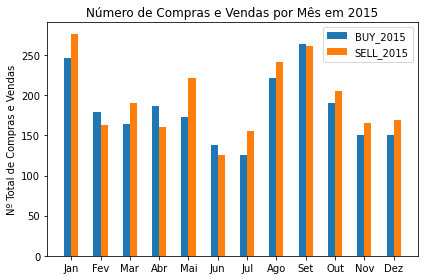

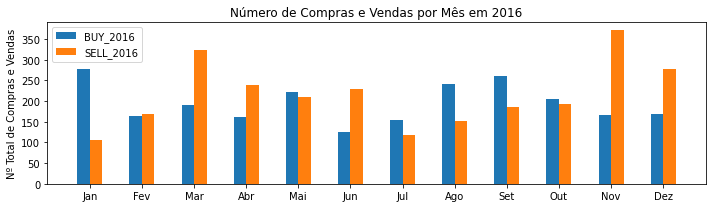

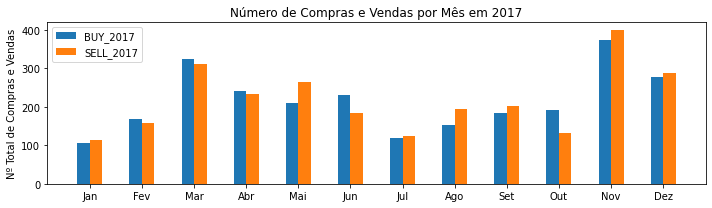

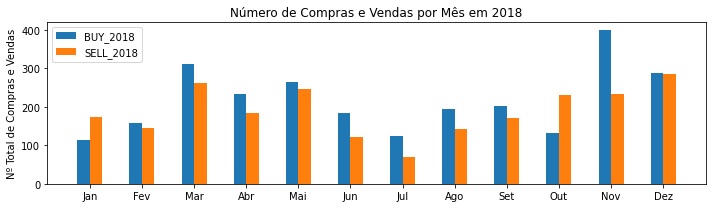

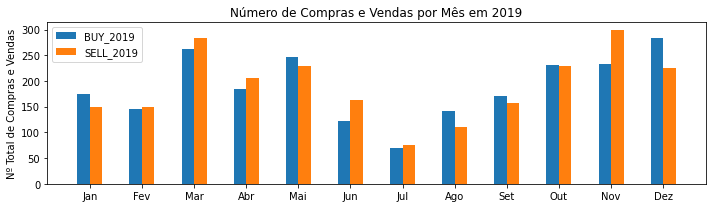

In [42]:
labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lista = []

for i in range(2015, 2020):
    
    buy  = df[df.DATETIME.dt.year == i].groupby(df.DATETIME.dt.month)['BUY'].sum()
    sell = df[df.DATETIME.dt.year == i].groupby(df.DATETIME.dt.month)['SELL'].sum()
    lista.append(buy)
    lista.append(sell)

x = np.arange(len(labels))  # the label locations
width = 0.24  # the width of the bars

for ano in range(int(len(lista) / 2)):
    aux = ano + 2015
    fig, ax = plt.subplots()
    ax.bar(x - 1*width/2, lista[ano]    , width, label='BUY_{}'.format(aux))
    ax.bar(x + 1*width/2, lista[ano + 1], width, label='SELL_{}'.format(aux))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Nº Total de Compras e Vendas')
    ax.set_title('Número de Compras e Vendas por Mês em {}'.format(aux))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.rcParams['figure.figsize'] = (10,3)
    plt.show()

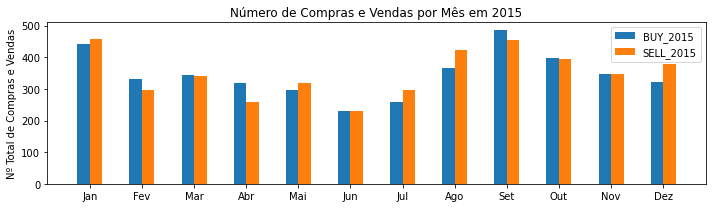

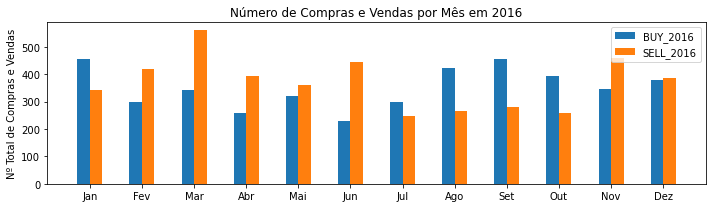

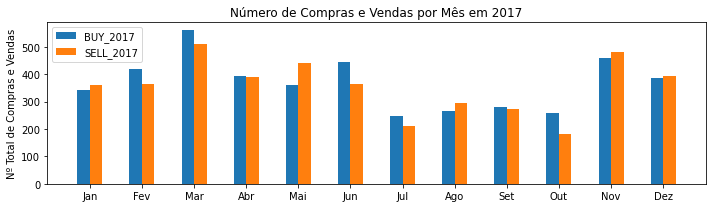

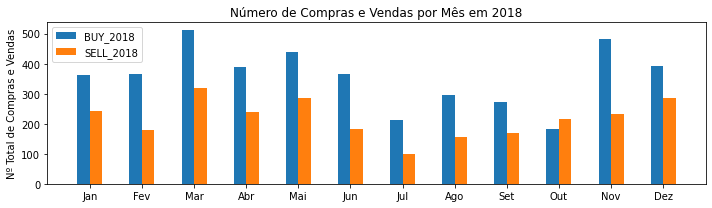

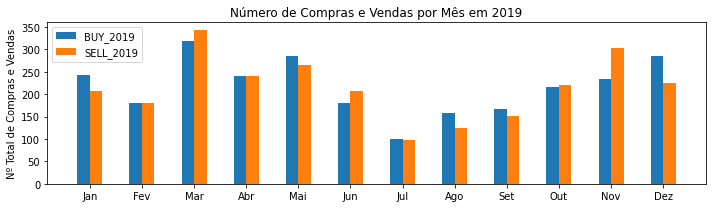

In [43]:
labels = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
lista = []

for i in range(2015, 2020):
    
    buy  = df[(df.DATETIME.dt.year == i) & (df.TARGET_PERCENTAGE == 'BUY')].groupby(df.DATETIME.dt.month)['TARGET_PERCENTAGE'].count()
    sell = df[(df.DATETIME.dt.year == i) & (df.TARGET_PERCENTAGE == 'SELL')].groupby(df.DATETIME.dt.month)['TARGET_PERCENTAGE'].count()
    lista.append(buy)
    lista.append(sell)

x = np.arange(len(labels))  # the label locations
width = 0.24  # the width of the bars

for ano in range(int(len(lista) / 2)):
    aux = ano + 2015
    fig, ax = plt.subplots()
    ax.bar(x - 1*width/2, lista[ano]    , width, label='BUY_{}'.format(aux))
    ax.bar(x + 1*width/2, lista[ano + 1], width, label='SELL_{}'.format(aux))
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Nº Total de Compras e Vendas')
    ax.set_title('Número de Compras e Vendas por Mês em {}'.format(aux))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.rcParams['figure.figsize'] = (10,3)
    plt.show()

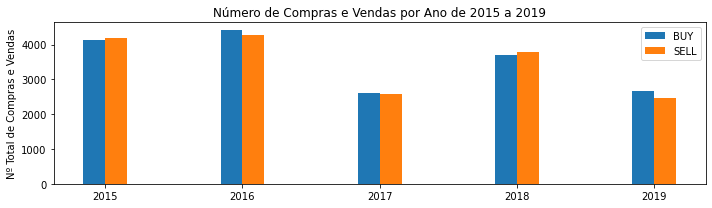

In [44]:
labels = ['2015', '2016', '2017', '2018', '2019']
buy  = df[(df.TARGET_PERCENTAGE == 'BUY')].groupby(df.DATETIME.dt.year)['TARGET_PERCENTAGE'].count()
sell = df[(df.TARGET_PERCENTAGE == 'SELL')].groupby(df.DATETIME.dt.year)['TARGET_PERCENTAGE'].count()

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()

ax.bar(x - 1*width/2, buy[1:6], width, label='BUY')
ax.bar(x + 1*width/2, sell[1:6], width, label='SELL')
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Nº Total de Compras e Vendas')
ax.set_title('Número de Compras e Vendas por Ano de 2015 a 2019')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.rcParams['figure.figsize'] = (10,7)
plt.show()


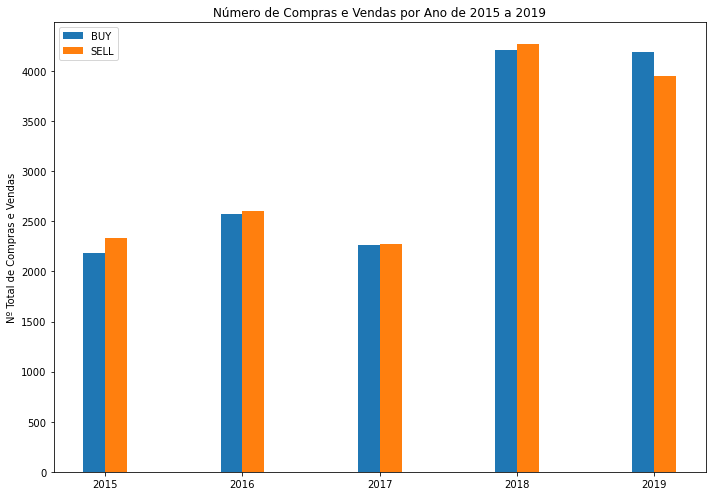

In [45]:
labels = ['2015', '2016', '2017', '2018', '2019']
buy  = df.groupby(df.DATETIME.dt.year)['BUY'].sum().values
sell = df.groupby(df.DATETIME.dt.year)['SELL'].sum().values

x = np.arange(len(labels))  # the label locations
width = 0.16  # the width of the bars

fig, ax = plt.subplots()

ax.bar(x - 1*width/2, buy[1:6], width, label='BUY')
ax.bar(x + 1*width/2, sell[1:6], width, label='SELL')
# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Nº Total de Compras e Vendas')
ax.set_title('Número de Compras e Vendas por Ano de 2015 a 2019')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.rcParams['figure.figsize'] = (10,7)
plt.show()


In [46]:
df.query('HORA_NOBRE == 2')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY


In [47]:
df.query('TARGET_WIN < -6000')

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,EMA_20,ADX_6,...,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE,TARGET_WIN_CAT_ENC,HOLD,SELL,BUY
66039,2017-05-17 17:40:00,2017.05.17,17:40:00,68000.0,68040.0,67995.0,68035.0,3798.0,67932.641213,31.250099,...,3,-6855.0,SELL,2,136.07,SELL,2,0,1,0
66040,2017-05-17 17:45:00,2017.05.17,17:45:00,68040.0,68050.0,67930.0,67930.0,4868.0,67932.389669,27.403466,...,3,-6750.0,SELL,2,135.86,SELL,2,0,1,0
66041,2017-05-17 17:50:00,2017.05.17,17:50:00,67940.0,68010.0,67930.0,67985.0,5819.0,67937.400176,24.197938,...,3,-6805.0,SELL,2,135.97,SELL,2,0,1,0


In [48]:
df['HORA_NOBRE']

0         2
1         2
2         2
3         2
4         2
         ..
139877    3
139878    3
139879    3
139880    3
139881    3
Name: HORA_NOBRE, Length: 139882, dtype: object

In [49]:
df.dtypes

DATETIME                 datetime64[ns]
DATE                             object
TIME                             object
OPEN                            float64
HIGH                            float64
LOW                             float64
CLOSE                           float64
VOL                             float64
EMA_20                          float64
ADX_6                           float64
MOM_6                           float64
ROC_5                           float64
RSI_10                          float64
OBV                             float64
MES                               int64
DIA_SEMANA                        int64
HORA_NOBRE                       object
TARGET_WIN                      float64
TARGET_WIN_CAT3                  object
TARGET_WIN_CAT3_LABEL             int64
PRICE_PERCENTAGE                float64
TARGET_PERCENTAGE                object
TARGET_WIN_CAT_ENC                int32
HOLD                              int64
SELL                              int64


In [50]:
#Determine a tabela pivot
impute_grps = df.pivot_table(values=["BUY"], index=["MES","DIA_SEMANA","HORA_NOBRE"], aggfunc=np.sum)
impute_grps

BUY
MES DIA_SEMANA HORA_NOBRE     
1   0          0            11
               1            75
               2            82
               3            69
    1          0            16
...                        ...
12  3          3            96
    4          0            18
               1           105
               2           139
               3            82

[240 rows x 1 columns]

### Esta primeira análise é feita com features categóricas de buy e sell de +/- 150 pontos e horizonte de previsão de 3 candles de 5min. 

### Para uma próxima análise fazer para:  
#### +/- 200 pontos
#### variação de +/- 0,2% (100k * 0,2% = 200)